# Utility Functions

In [1]:
# set the project path
%cd ~/projects/drug-pricing

/Users/cccdenhart/projects/drug-pricing


In [38]:
from collections import Counter
from datetime import datetime, date
import functools as ft
import itertools as it
import os
from typing import List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from praw import Reddit
from psaw import PushshiftAPI
import seaborn as sns
import spacy
from spacy.lang.en import English
from spacy.tokens import DocBin
from tqdm import tqdm

from src.utils import connect_to_mongo
from src.schema import Post, CommentPost, SubmissionPost, User
from src.tasks.spacy import bytes_to_spacy

In [3]:
# project-wide variables/execution
nlp = spacy.load("en_core_web_sm")
connect_to_mongo()

# Read in data

# Summative Visualizations

## Number of Posts Over Time

In [36]:
# an aggregation pipeline for grouping posts by year
year_count_pipeline = [{ 
    "$group": { 
        "_id": {"year": {"$year": "$datetime"}}, 
        "count": {"$sum": 1}
    }
}]

### Count of Submissions Over Time

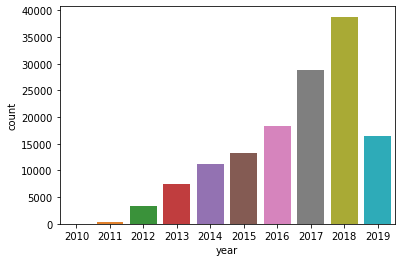

In [75]:
# format data
query = list(SubmissionPost.objects.aggregate(year_count_pipeline))
years = [str(it["_id"]["year"]) for it in query]
submission_counts = [it["count"] for it in query]
df = pd.DataFrame({"year": years, "count": submission_counts})

# plot
sns.barplot(x="year", y="count", data=df)
plt.show()

### Count of Submissions + Comments Over Time

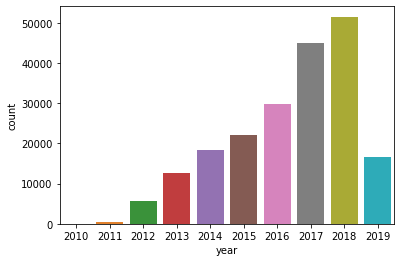

In [76]:
# extract data
query = list(Post.objects.aggregate(year_count_pipeline))
years = [str(it["_id"]["year"]) for it in query]
post_counts = [it["count"] for it in query]
df = pd.DataFrame({"year": years, "count": post_counts})

# plot
sns.barplot(x="year", y="count", data=df)
plt.show()

### Real comments vs. extracted comments

In [46]:
pipeline = [{
    "$group": {
        "_id": {"year": {"$year": "$datetime"}},
        "count": {"$sum": "$num_comments"}
    }
}]
query = SubmissionPost.objects.aggregate(pipeline)
real_df = pd.DataFrame(list(query))
real_df["year"] = real_df["_id"].apply(lambda x: x["year"])

In [47]:
# group by year
pipeline = [{
    "$group": {
        "_id": {"year": {"$year": "$datetime"}}, 
        "count": {"$sum": 1}
    }
}]
query = CommentPost.objects.aggregate(pipeline)
raw_df = pd.DataFrame(list(query))
raw_df["year"] = raw_df["_id"].apply(lambda x: x["year"])

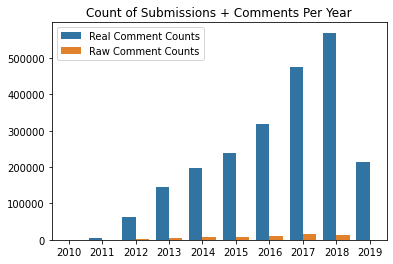

In [48]:
# combine dataframes
comm_df = real_df.merge(raw_df, on="year", how="inner")

# plot
years = comm_df["year"].tolist() * 2
label = ["Real Comment Counts"] * comm_df.shape[0] + \
        ["Raw Comment Counts"] * comm_df.shape[0]
counts = comm_df["count_x"].tolist() + comm_df["count_y"].tolist()
ax = sns.barplot(x=years, y=counts, hue=label)
ax.set_title("Count of Submissions + Comments Per Year")
plt.show()

### Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

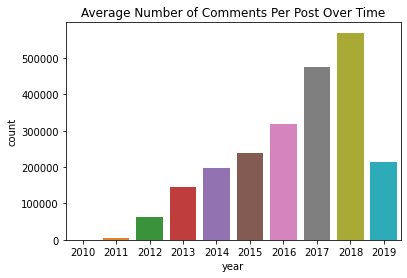

In [52]:
comm_df = real_df.loc[:,["year", "count"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df["year"], y=comm_df["count"])
ax.set_title("Average Number of Comments Per Post Over Time")

## Active Number of Users on R/Opiates Over Time

In [73]:
pipeline = [{
    "$group": {
        "_id": {
            "year": {"$year": "$datetime"}
        },
        "num_users": {"$count": "$user"}
    }
}]

In [74]:
query = Post.objects.aggregate(pipeline)

OperationFailure: unknown group operator '$count'

In [64]:
df = pd.DataFrame(list(query))

In [60]:
df = pd.DataFrame(list(query))
ax = sns.barplot(x="year", y="num_users", data=df)
ax.set_title("Number of r/opiates Active Users Over Time")

ValueError: Could not interpret input 'year'

## Frequency Table

In [77]:
df = pd.DataFrame({"years": years, "Submissions": submission_counts, "Totals": post_counts})

In [78]:
df

,years,Submissions,Totals
0,2010,42,47
1,2011,262,410
2,2012,3302,5576
3,2013,7415,12634
4,2014,11120,18372
5,2015,13336,22109
6,2016,18282,29906
7,2017,28769,45147
8,2018,38791,51575
9,2019,16442,16574


# Task Demonstrations

## spaCy Visualization

### San Pedro Example

In [11]:
san_pedro_posts = Post.objects(text__icontains="san pedro")
san_pedro_docs = [bytes_to_spacy(post.spacy, nlp) for post in san_pedro_posts]

In [13]:
for doc in san_pedro_docs:
    spacy.displacy.render(doc, style="ent")

### Boston Example

In [24]:
posts = Post.objects(text__icontains="boston").limit(10)
docs = [bytes_to_spacy(post.spacy, nlp) for post in posts]

In [25]:
for i, doc in enumerate(docs):
    print(f"Doc {i}:")
    spacy.displacy.render(doc, style="ent")
    print()

Doc 0:



Doc 1:



Doc 2:



Doc 3:



Doc 4:



Doc 5:



Doc 6:



Doc 7:



Doc 8:



Doc 9:
